In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
path = '/content/drive/My Drive/kaggle/atmacup11/'
os.chdir(path) # カレントディレクトリを指定
os.getcwd()

'/content/drive/My Drive/kaggle/atmacup11'

In [18]:
!pip install timm
!pip install pytorch-lightning
!pip install ttach
!pip uninstall -y scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install albumentations -U

Found existing installation: scikit-learn 1.0.dev0
Uninstalling scikit-learn-1.0.dev0:
  Successfully uninstalled scikit-learn-1.0.dev0
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.9 MB 1.8 MB/s 


# Code

In [25]:
import os
import sys
from collections import OrderedDict

# Third Parties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

# PyTorch
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T
from torchvision.models import resnet34
import timm

# pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
import cv2

# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedGroupKFold

In [20]:
# 定数たち
IS_DEBUG = False
N_SPLITS = 2 if IS_DEBUG else 5
MAX_EPOCHS = 3 if IS_DEBUG else 200
ES_PATIENCE = 25
RLR_PATIENCE = 7
RLR_FACTOR = 0.25
BATCH_SIZE = 128
NUM_WORKERS = 10

In [26]:
dataset_root = os.path.join(path, 'dataset_atmaCup11/')

assert dataset_root is not None

input_dir = os.path.join(dataset_root)
photo_dir = os.path.join(input_dir, "photos")

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

In [27]:
def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

In [28]:
class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    target_key = "target"

    @property
    def meta_keys(self):
        """"""
        retval = [self.object_path_key]

        if self.phase == 'train' or self.phase == 'valid':
            retval.append(self.target_key)

        return retval

    def __init__(self, meta_df: pd.DataFrame, phase='train', transform=None):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            phase:
                train のとき学習用のデータ拡張を適用します.
                train 以外の時は単に size にリサイズを行います

            transform:
                画像にかける変換処理
        """

        self.phase = phase
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError(f"meta_df must have {k}")

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")
        self.transform = transform

        size = (224, 224)

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, target = (data.get(self.object_path_key),
                            data.get(self.target_key, -1),)
        
        img = cv2.imread(obj_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        # img /= 255.0
        img = self.transform(**{'image': img})['image']
        # img = Image.open(obj_path)
        # img = self.transform(img)

        if self.phase == 'test':
            return img

        return img, target

    def __len__(self):
        return len(self.meta_df)

In [29]:
class AtmaDataModule(pl.LightningDataModule):
    def __init__(self,
                 dataset_root: str = '../input',
                 batch_size: int = 32,
                 fold: int = 0,
                 num_workers: int = 20,):

        super().__init__()
        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.fold = fold
        self.num_workers=num_workers

    def get_test_df(self):
        return pd.read_csv(os.path.join(self.dataset_root, 'test.csv'))

    def split_train_valid_df(self):
        df = pd.read_csv(os.path.join(self.dataset_root, 'train.csv'))

        # Split
        skf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        # kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        for i, (train_idx, valid_idx) in enumerate(skf.split(df, y=df['target'], groups=df['art_series_id'])):
            df.loc[valid_idx, 'fold'] = int(i)
        df['fold'] = df['fold'].astype(int)

        train_df = df[df['fold'] != self.fold].reset_index(drop=True)
        valid_df = df[df['fold'] == self.fold].reset_index(drop=True)
        return train_df, valid_df

    def setup(self, stage=None):
        self.test_df = self.get_test_df()
        train_df, valid_df = self.split_train_valid_df()
        self.train_df = train_df
        self.valid_df = valid_df

    def get_dataframe(self, phase):
        assert phase in {'train', 'valid', 'test'}
        if phase == 'train':
            return self.train_df
        elif phase == "valid":
            return self.valid_df
        elif phase == "test":
            return self.test_df

    def get_transform(self, phase):
        assert phase in {'train', 'valid', 'test'}
        IMG_MEAN = [0.485, 0.456, 0.406]
        IMG_STD = [0.229, 0.224, 0.225]
        size = (224, 224)

        if phase=='train':
          transform = A.Compose([
            A.ToGray(p=0.01),
            A.ToSepia(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
            A.CoarseDropout(max_holes=16, max_height=24, max_width=24, min_height=8, min_width=8, fill_value=0, p=0.2),
            A.RandomResizedCrop(scale=(0.3, 1.0), height=224, width=224, p=1.0),
            ToTensorV2(p=1.0)
          ])
          # https://arxiv.org/abs/2011.10566 参照
          transform = A.Compose([
            A.RandomResizedCrop(p=1.0, scale=(0.2, 1.0), height=224, width=224),
            # A.ColorJitter(p=0.8, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            # A.ToGray(p=0.2),
            # A.GaussianBlur(p=0.5, sigma_limit=(0.1, 2.0)),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Normalize(p=1.0, mean=(0.776, 0.742, 0.669), std=(0.115, 0.113, 0.114), max_pixel_value=255.0),
            A.ToTensorV2(always_apply=True)
        ])
        else:
          transform = A.Compose([
            Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
            A.Resize(height=224, width=224, p=1),
            ToTensorV2(p=1.0)
          ])

        return transform

    def get_ds(self, phase):
        assert phase in {"train", "valid", "test"}
        ds = AtmaDataset(
            meta_df=create_metadata(self.get_dataframe(phase=phase)),
            transform=self.get_transform(phase=phase),
            phase=phase,
        )
        return ds

    def get_loader(self, phase):
        dataset = self.get_ds(phase=phase)

        return data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True if phase == "train" else False,
            num_workers=self.num_workers,
            drop_last=True if phase == "train" else False,
        )

    def train_dataloader(self):
        return self.get_loader(phase='train')

    def val_dataloader(self):
        return self.get_loader(phase='valid')

    def predict_dataloader(self):
        return self.get_loader(phase='test')

In [30]:
class LitModule(pl.LightningModule):

    def get_model(self):
        model = timm.create_model('efficientnet_b0', pretrained=False)
        model.classifier = self.eff_fc_layer()
        return model

    def eff_fc_layer(self):
        fc_list = [nn.Linear(in_features=1280, out_features=32, bias=True),
                   nn.Dropout(0.2),
                   nn.Linear(in_features=32, out_features=1, bias=True)]
        return nn.Sequential(*fc_list)

    def get_crit(self):
        return nn.MSELoss()

    def calculate_elapsed_time(self):
        elapsed_time = int(time.time() - self.start_time)
        elapsed_minute = (elapsed_time % 3600) / 60
        return elapsed_minute

    def __init__(self):
        super(LitModule, self).__init__()
        self.net = self.get_model()
        self.crit = self.get_crit()
        self.start_time = time.time()

    def forward(self, x):
        output = self.net(x).squeeze(1)
        return output

    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        output = self(imgs)
        loss = self.crit(output, targets.float())
        return loss

    def training_epoch_end(self, outputs):
        train_epoch_loss = torch.stack([o["loss"] for o in outputs]).mean().item()
        self.log('train_loss', train_epoch_loss)
        print(f'train_epoch_loss : {train_epoch_loss}')

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch
        preds = self(imgs)
        loss = self.crit(preds, targets.float())

        output = OrderedDict({
            "preds": preds.detach(),
            "targets": targets.detach(),
            "loss": loss.detach(),
        })
        return output

    def validation_epoch_end(self, outputs):
        d = dict()
        d["epoch"] = int(self.current_epoch)
        d["valid_loss"] = torch.stack([o["loss"] for o in outputs]).mean().item()

        preds = torch.cat([o["preds"].view(-1) for o in outputs]).cpu().numpy()
        targets = torch.cat([o["targets"].view(-1) for o in outputs]).cpu().numpy()

        mse_target = mean_squared_error(y_true=targets, y_pred=preds)
        d["valid_mse_target"] = mse_target

        d["elapsed_minute"] = self.calculate_elapsed_time()

        self.log_dict(d)
        print(d)

    def configure_optimizers(self):
        optimizer = Adam(self.net.parameters(), lr=5e-3)
        lr_scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=RLR_FACTOR, patience=RLR_PATIENCE),
            'monitor': 'valid_loss',
        }

        return [optimizer], [lr_scheduler]

# Train

In [31]:
class NotebookProgress(ProgressBarBase):

    def __init__(self):
        super().__init__()  # don't forget this :)
        self.enable = True

    def disable(self):
        self.enable = False

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)  # don't forget this :)
        percent = (self.train_batch_idx / self.total_train_batches) * 100
        sys.stdout.flush()
        sys.stdout.write(f'{percent:.01f} percent complete \r')

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_validation_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)

In [32]:
def train(cfg_name: str, output_path: str, fold: int,) -> None:
    seed_everything(42)

    logger = CSVLogger(save_dir=output_path, name=f"fold_{fold}")
    # wandb_logger = WandbLogger(name=f"{cfg_name}_{fold}", project='ore', offline=IS_DEBUG)

    # 学習済重みを保存するために必要
    checkpoint_callback = ModelCheckpoint(
        dirpath=str(output_path), filename=f"{cfg_name}_{fold}",
        save_weights_only=True,
        save_top_k=None,
        monitor='valid_mse_target',
    )

    early_stop_callback = EarlyStopping(
        monitor='valid_mse_target',
        min_delta=0.00,
        patience=ES_PATIENCE,
        verbose=False,
        mode='min'
    )

    progress = NotebookProgress()
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    trainer = Trainer(
        max_epochs=MAX_EPOCHS,
        gpus=1,
        callbacks=[checkpoint_callback, 
                   early_stop_callback,
                   progress,
                   lr_monitor,],
        logger=[logger, ],
        limit_train_batches=0.02 if IS_DEBUG else 1.0,
        limit_val_batches=0.05 if IS_DEBUG else 1.0,
    )

    model = LitModule()
    datamodule = AtmaDataModule(dataset_root=dataset_root,
                                batch_size=BATCH_SIZE,
                                fold = fold,
                                num_workers=NUM_WORKERS)
    trainer.fit(model, datamodule=datamodule)

    return checkpoint_callback.best_model_path, checkpoint_callback.best_model_score

In [33]:
%%time
output_path = './output/effnet/'
os.makedirs(output_path, exist_ok=True)
best_model_paths = []

sum_mse = 0
for fold in tqdm(range(N_SPLITS)):
    best_model_path, best_model_score = train(cfg_name=f'pl_first', output_path=output_path, fold=fold)
    best_model_paths.append(best_model_path)

    sum_mse += best_model_score / N_SPLITS
    print(f'best_model_path : {best_model_path}')
    print(f'best_model_score : {best_model_score}')

# CVスコアを表示
print(sum_mse ** 0.5)

  0%|          | 0/5 [00:00<?, ?it/s]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.5704007148742676, 'valid_mse_target': 3.570400559178358, 'elapsed_minute': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 3.545475721359253
{'epoch': 0, 'valid_loss': 1.9072673320770264, 'valid_mse_target': 1.7699509595928233, 'elapsed_minute': 0.23333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 1.0719258785247803
{'epoch': 1, 'valid_loss': 1.4062457084655762, 'valid_mse_target': 1.3529376245602147, 'elapsed_minute': 0.4166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9914931058883667
{'epoch': 2, 'valid_loss': 1.0498707294464111, 'valid_mse_target': 0.9650055439921009, 'elapsed_minute': 0.6}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8887444734573364
{'epoch': 3, 'valid_loss': 0.9579905271530151, 'valid_mse_target': 0.9025539096014928, 'elapsed_minute': 0.7833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8371022939682007
{'epoch': 4, 'valid_loss': 0.9447197914123535, 'valid_mse_target': 0.8586678693421094, 'elapsed_minute': 0.9666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8605970144271851
{'epoch': 5, 'valid_loss': 0.9160721898078918, 'valid_mse_target': 0.8442514262756715, 'elapsed_minute': 1.15}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8582801818847656
{'epoch': 6, 'valid_loss': 0.910997748374939, 'valid_mse_target': 0.8287597309737893, 'elapsed_minute': 1.3333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8611301183700562
{'epoch': 7, 'valid_loss': 0.8822866678237915, 'valid_mse_target': 0.8208132823966412, 'elapsed_minute': 1.5166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8191661834716797
{'epoch': 8, 'valid_loss': 0.9058917760848999, 'valid_mse_target': 0.8573790546445029, 'elapsed_minute': 1.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8096935153007507
{'epoch': 9, 'valid_loss': 0.8512663245201111, 'valid_mse_target': 0.7711214084568287, 'elapsed_minute': 1.8833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7754680514335632
{'epoch': 10, 'valid_loss': 0.8344210386276245, 'valid_mse_target': 0.7805049805817161, 'elapsed_minute': 2.066666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7731112241744995
{'epoch': 11, 'valid_loss': 0.8756611347198486, 'valid_mse_target': 0.813507194435653, 'elapsed_minute': 2.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7650997042655945
{'epoch': 12, 'valid_loss': 0.9774572849273682, 'valid_mse_target': 0.9035294155167222, 'elapsed_minute': 2.433333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.776618480682373
{'epoch': 13, 'valid_loss': 0.9292299747467041, 'valid_mse_target': 0.8773403387215494, 'elapsed_minute': 2.6166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7654814720153809
{'epoch': 14, 'valid_loss': 1.0425381660461426, 'valid_mse_target': 0.9232631493556188, 'elapsed_minute': 2.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7704452872276306
{'epoch': 15, 'valid_loss': 0.8725740313529968, 'valid_mse_target': 0.7964365322603804, 'elapsed_minute': 2.9833333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7349953651428223
{'epoch': 16, 'valid_loss': 0.9393474459648132, 'valid_mse_target': 0.8725297367627269, 'elapsed_minute': 3.1666666666666665}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7193910479545593
{'epoch': 17, 'valid_loss': 0.76826012134552, 'valid_mse_target': 0.7198343068347138, 'elapsed_minute': 3.35}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7168366312980652
{'epoch': 18, 'valid_loss': 0.809406042098999, 'valid_mse_target': 0.7759449173078896, 'elapsed_minute': 3.5166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7226943373680115
{'epoch': 19, 'valid_loss': 0.7580453753471375, 'valid_mse_target': 0.7337222099452269, 'elapsed_minute': 3.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7015490531921387
{'epoch': 20, 'valid_loss': 0.8214234709739685, 'valid_mse_target': 0.7555499540806234, 'elapsed_minute': 3.9}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7188252210617065
{'epoch': 21, 'valid_loss': 0.7619903683662415, 'valid_mse_target': 0.7232980678999522, 'elapsed_minute': 4.083333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6908888816833496
{'epoch': 22, 'valid_loss': 0.7493223547935486, 'valid_mse_target': 0.7227414429511269, 'elapsed_minute': 4.266666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6818806529045105
{'epoch': 23, 'valid_loss': 0.8348979353904724, 'valid_mse_target': 0.7891159183047378, 'elapsed_minute': 4.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6828832030296326
{'epoch': 24, 'valid_loss': 0.9247869253158569, 'valid_mse_target': 0.8408498492857881, 'elapsed_minute': 4.616666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6760035753250122
{'epoch': 25, 'valid_loss': 0.788224458694458, 'valid_mse_target': 0.7618366302620528, 'elapsed_minute': 4.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6766757965087891
{'epoch': 26, 'valid_loss': 0.8222293257713318, 'valid_mse_target': 0.7679662683059044, 'elapsed_minute': 4.983333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.679689347743988
{'epoch': 27, 'valid_loss': 0.8601164817810059, 'valid_mse_target': 0.7872011264980946, 'elapsed_minute': 5.166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.674902617931366
{'epoch': 28, 'valid_loss': 0.9124037027359009, 'valid_mse_target': 0.9025725838120185, 'elapsed_minute': 5.35}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6698418855667114
{'epoch': 29, 'valid_loss': 0.8684004545211792, 'valid_mse_target': 0.8008730843325956, 'elapsed_minute': 5.533333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.668813943862915
{'epoch': 30, 'valid_loss': 0.7500830888748169, 'valid_mse_target': 0.7340212365245079, 'elapsed_minute': 5.716666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6314364671707153
{'epoch': 31, 'valid_loss': 0.7456671595573425, 'valid_mse_target': 0.7304471038698065, 'elapsed_minute': 5.9}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6079877614974976
{'epoch': 32, 'valid_loss': 0.7131534814834595, 'valid_mse_target': 0.6933458046064863, 'elapsed_minute': 6.083333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5736023187637329
{'epoch': 33, 'valid_loss': 0.6986444592475891, 'valid_mse_target': 0.6717229748159903, 'elapsed_minute': 6.266666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5907454490661621
{'epoch': 34, 'valid_loss': 0.7255200147628784, 'valid_mse_target': 0.6815626159668885, 'elapsed_minute': 6.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5759078860282898
{'epoch': 35, 'valid_loss': 0.7363582849502563, 'valid_mse_target': 0.7078010408487906, 'elapsed_minute': 6.633333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5578963160514832
{'epoch': 36, 'valid_loss': 0.6828644275665283, 'valid_mse_target': 0.6706008745942459, 'elapsed_minute': 6.816666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5843417048454285
{'epoch': 37, 'valid_loss': 0.7506234645843506, 'valid_mse_target': 0.7126901018311864, 'elapsed_minute': 7.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5638458728790283
{'epoch': 38, 'valid_loss': 0.7108875513076782, 'valid_mse_target': 0.6924420450784551, 'elapsed_minute': 7.183333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5649818778038025
{'epoch': 39, 'valid_loss': 0.7374215722084045, 'valid_mse_target': 0.7176972526826711, 'elapsed_minute': 7.366666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5833979845046997
{'epoch': 40, 'valid_loss': 0.6768630146980286, 'valid_mse_target': 0.6503623751974075, 'elapsed_minute': 7.55}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5763143301010132
{'epoch': 41, 'valid_loss': 0.7287343144416809, 'valid_mse_target': 0.6985399600019812, 'elapsed_minute': 7.733333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5602558851242065
{'epoch': 42, 'valid_loss': 0.6994510293006897, 'valid_mse_target': 0.693295436848637, 'elapsed_minute': 7.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5574238300323486
{'epoch': 43, 'valid_loss': 0.7314055562019348, 'valid_mse_target': 0.6793745086161669, 'elapsed_minute': 8.116666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5639616250991821
{'epoch': 44, 'valid_loss': 0.6839926838874817, 'valid_mse_target': 0.6822998356772884, 'elapsed_minute': 8.283333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5485894083976746
{'epoch': 45, 'valid_loss': 0.7027755975723267, 'valid_mse_target': 0.6827252259124786, 'elapsed_minute': 8.466666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.530712366104126
{'epoch': 46, 'valid_loss': 0.7471535801887512, 'valid_mse_target': 0.71262432073812, 'elapsed_minute': 8.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5397173762321472
{'epoch': 47, 'valid_loss': 0.7607592344284058, 'valid_mse_target': 0.7384378711039046, 'elapsed_minute': 8.85}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5411495566368103
{'epoch': 48, 'valid_loss': 0.7174625992774963, 'valid_mse_target': 0.7009948419392442, 'elapsed_minute': 9.016666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5177063345909119
{'epoch': 49, 'valid_loss': 0.6895440220832825, 'valid_mse_target': 0.6728969056804867, 'elapsed_minute': 9.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5251901745796204
{'epoch': 50, 'valid_loss': 0.691153347492218, 'valid_mse_target': 0.6773430395164278, 'elapsed_minute': 9.383333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5034736394882202
{'epoch': 51, 'valid_loss': 0.7092524170875549, 'valid_mse_target': 0.6855978041600673, 'elapsed_minute': 9.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5061071515083313
{'epoch': 52, 'valid_loss': 0.6921910047531128, 'valid_mse_target': 0.6686915019145404, 'elapsed_minute': 9.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5032200813293457
{'epoch': 53, 'valid_loss': 0.7155550718307495, 'valid_mse_target': 0.6854284234879533, 'elapsed_minute': 9.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.49099433422088623
{'epoch': 54, 'valid_loss': 0.6769711375236511, 'valid_mse_target': 0.6739552986090641, 'elapsed_minute': 10.116666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.49127551913261414
{'epoch': 55, 'valid_loss': 0.6701480746269226, 'valid_mse_target': 0.6718062944331082, 'elapsed_minute': 10.3}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.49105584621429443
{'epoch': 56, 'valid_loss': 0.684062123298645, 'valid_mse_target': 0.6806896773389554, 'elapsed_minute': 10.483333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5091781616210938
{'epoch': 57, 'valid_loss': 0.6656274795532227, 'valid_mse_target': 0.6609306754178472, 'elapsed_minute': 10.683333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4869871735572815
{'epoch': 58, 'valid_loss': 0.6882671117782593, 'valid_mse_target': 0.6888080660845556, 'elapsed_minute': 10.85}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4969902038574219
{'epoch': 59, 'valid_loss': 0.6780639886856079, 'valid_mse_target': 0.6805338337850756, 'elapsed_minute': 11.033333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4867943227291107
{'epoch': 60, 'valid_loss': 0.7034021615982056, 'valid_mse_target': 0.6759275807374381, 'elapsed_minute': 11.216666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4995644688606262
{'epoch': 61, 'valid_loss': 0.6638001203536987, 'valid_mse_target': 0.6663662596537755, 'elapsed_minute': 11.4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4819300174713135
{'epoch': 62, 'valid_loss': 0.6844961047172546, 'valid_mse_target': 0.687789974211143, 'elapsed_minute': 11.583333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5007097721099854
{'epoch': 63, 'valid_loss': 0.698323130607605, 'valid_mse_target': 0.6848735097442116, 'elapsed_minute': 11.766666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.48730048537254333
{'epoch': 64, 'valid_loss': 0.7113274335861206, 'valid_mse_target': 0.6862519119040149, 'elapsed_minute': 11.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.4961126744747162
{'epoch': 65, 'valid_loss': 0.6847725510597229, 'valid_mse_target': 0.6851074584935543, 'elapsed_minute': 12.133333333333333}


 20%|██        | 1/5 [12:09<48:36, 729.03s/it]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


best_model_path : /content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_0-v4.ckpt
best_model_score : 0.6503623723983765


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.5790538787841797, 'valid_mse_target': 3.5790538101332396, 'elapsed_minute': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 3.6053109169006348
{'epoch': 0, 'valid_loss': 1.0884274244308472, 'valid_mse_target': 1.055295739257194, 'elapsed_minute': 0.23333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 1.0054597854614258
{'epoch': 1, 'valid_loss': 1.0825409889221191, 'valid_mse_target': 1.0635803722022406, 'elapsed_minute': 0.4166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9588610529899597
{'epoch': 2, 'valid_loss': 0.891646683216095, 'valid_mse_target': 0.8583424598906493, 'elapsed_minute': 0.6}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9172401428222656
{'epoch': 3, 'valid_loss': 0.9225597977638245, 'valid_mse_target': 0.9117592149660209, 'elapsed_minute': 0.7833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.896014392375946
{'epoch': 4, 'valid_loss': 0.7934912443161011, 'valid_mse_target': 0.790828916269134, 'elapsed_minute': 0.9666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8927551507949829
{'epoch': 5, 'valid_loss': 0.793471097946167, 'valid_mse_target': 0.7845612394244875, 'elapsed_minute': 1.15}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8568862676620483
{'epoch': 6, 'valid_loss': 0.7493063807487488, 'valid_mse_target': 0.7348228509783388, 'elapsed_minute': 1.3333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8379428386688232
{'epoch': 7, 'valid_loss': 0.7184661030769348, 'valid_mse_target': 0.7055567219675488, 'elapsed_minute': 1.5333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8369292616844177
{'epoch': 8, 'valid_loss': 0.7637792825698853, 'valid_mse_target': 0.7572478367227141, 'elapsed_minute': 1.7166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8233594298362732
{'epoch': 9, 'valid_loss': 0.8119882345199585, 'valid_mse_target': 0.7944875503114724, 'elapsed_minute': 1.9}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8252371549606323
{'epoch': 10, 'valid_loss': 0.7573391199111938, 'valid_mse_target': 0.7416401411179757, 'elapsed_minute': 2.0833333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7896771430969238
{'epoch': 11, 'valid_loss': 0.8106935620307922, 'valid_mse_target': 0.7842955009033449, 'elapsed_minute': 2.2666666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7992141246795654
{'epoch': 12, 'valid_loss': 0.814278781414032, 'valid_mse_target': 0.7935366598164586, 'elapsed_minute': 2.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7680296301841736
{'epoch': 13, 'valid_loss': 0.7360363602638245, 'valid_mse_target': 0.7223164064618314, 'elapsed_minute': 2.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7696172595024109
{'epoch': 14, 'valid_loss': 0.6943010687828064, 'valid_mse_target': 0.6783410016492654, 'elapsed_minute': 2.8333333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7605686187744141
{'epoch': 15, 'valid_loss': 0.707978367805481, 'valid_mse_target': 0.6830663954692976, 'elapsed_minute': 3.0166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7907501459121704
{'epoch': 16, 'valid_loss': 0.6806803345680237, 'valid_mse_target': 0.6763866780558078, 'elapsed_minute': 3.216666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7608343958854675
{'epoch': 17, 'valid_loss': 0.6784812211990356, 'valid_mse_target': 0.6716558221868797, 'elapsed_minute': 3.4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7536162734031677
{'epoch': 18, 'valid_loss': 0.7461308240890503, 'valid_mse_target': 0.7716275808010843, 'elapsed_minute': 3.5833333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.735262393951416
{'epoch': 19, 'valid_loss': 0.7465999126434326, 'valid_mse_target': 0.7461999254087135, 'elapsed_minute': 3.7666666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7263774871826172
{'epoch': 20, 'valid_loss': 0.7823618650436401, 'valid_mse_target': 0.7900303611964532, 'elapsed_minute': 3.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7225641012191772
{'epoch': 21, 'valid_loss': 0.7279850244522095, 'valid_mse_target': 0.7323802633481956, 'elapsed_minute': 4.133333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6981159448623657
{'epoch': 22, 'valid_loss': 0.7626330256462097, 'valid_mse_target': 0.7384700256450699, 'elapsed_minute': 4.333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7187460660934448
{'epoch': 23, 'valid_loss': 0.8432270884513855, 'valid_mse_target': 0.8311386354300041, 'elapsed_minute': 4.516666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7155236601829529
{'epoch': 24, 'valid_loss': 0.7402183413505554, 'valid_mse_target': 0.7397207359311286, 'elapsed_minute': 4.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7000352740287781
{'epoch': 25, 'valid_loss': 0.7260105013847351, 'valid_mse_target': 0.7197338510663772, 'elapsed_minute': 4.883333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6938562393188477
{'epoch': 26, 'valid_loss': 0.7069067358970642, 'valid_mse_target': 0.7282131767891533, 'elapsed_minute': 5.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.660331130027771
{'epoch': 27, 'valid_loss': 0.6318588256835938, 'valid_mse_target': 0.6367982159954804, 'elapsed_minute': 5.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6512678861618042
{'epoch': 28, 'valid_loss': 0.6494040489196777, 'valid_mse_target': 0.6457986095327705, 'elapsed_minute': 5.433333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.658168613910675
{'epoch': 29, 'valid_loss': 0.6257328391075134, 'valid_mse_target': 0.6292933841433179, 'elapsed_minute': 5.616666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6410776972770691
{'epoch': 30, 'valid_loss': 0.7511318922042847, 'valid_mse_target': 0.7439102008623929, 'elapsed_minute': 5.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6411189436912537
{'epoch': 31, 'valid_loss': 0.6729417443275452, 'valid_mse_target': 0.660306063698517, 'elapsed_minute': 5.983333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6385902762413025
{'epoch': 32, 'valid_loss': 0.6245911121368408, 'valid_mse_target': 0.6276098298494718, 'elapsed_minute': 6.166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.644828200340271
{'epoch': 33, 'valid_loss': 0.6509759426116943, 'valid_mse_target': 0.6464375444772902, 'elapsed_minute': 6.35}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6442574262619019
{'epoch': 34, 'valid_loss': 0.638024628162384, 'valid_mse_target': 0.646386382499286, 'elapsed_minute': 6.55}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6432924270629883
{'epoch': 35, 'valid_loss': 0.6402021646499634, 'valid_mse_target': 0.6438409187262002, 'elapsed_minute': 6.733333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6266210675239563
{'epoch': 36, 'valid_loss': 0.6529181599617004, 'valid_mse_target': 0.6526083516684414, 'elapsed_minute': 6.916666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6417719125747681
{'epoch': 37, 'valid_loss': 0.660968005657196, 'valid_mse_target': 0.6527122389083977, 'elapsed_minute': 7.1}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6283547282218933
{'epoch': 38, 'valid_loss': 0.6415081024169922, 'valid_mse_target': 0.6388377175055833, 'elapsed_minute': 7.283333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6213440895080566
{'epoch': 39, 'valid_loss': 0.6478582620620728, 'valid_mse_target': 0.6468581053083351, 'elapsed_minute': 7.466666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6215208768844604
{'epoch': 40, 'valid_loss': 0.6530790328979492, 'valid_mse_target': 0.6505989682793262, 'elapsed_minute': 7.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5974873900413513
{'epoch': 41, 'valid_loss': 0.6194249987602234, 'valid_mse_target': 0.622926276106822, 'elapsed_minute': 7.85}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5972192287445068
{'epoch': 42, 'valid_loss': 0.6160279512405396, 'valid_mse_target': 0.6167793859580831, 'elapsed_minute': 8.033333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6075131893157959
{'epoch': 43, 'valid_loss': 0.6169760823249817, 'valid_mse_target': 0.6196213740992159, 'elapsed_minute': 8.216666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6009500026702881
{'epoch': 44, 'valid_loss': 0.6085445284843445, 'valid_mse_target': 0.6070457165875376, 'elapsed_minute': 8.4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6023174524307251
{'epoch': 45, 'valid_loss': 0.6187541484832764, 'valid_mse_target': 0.6207508831377104, 'elapsed_minute': 8.583333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5908240675926208
{'epoch': 46, 'valid_loss': 0.6101891994476318, 'valid_mse_target': 0.6153605085099211, 'elapsed_minute': 8.783333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5985167026519775
{'epoch': 47, 'valid_loss': 0.6187675595283508, 'valid_mse_target': 0.6174410133630378, 'elapsed_minute': 8.966666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5908416509628296
{'epoch': 48, 'valid_loss': 0.6178267598152161, 'valid_mse_target': 0.6257141538815234, 'elapsed_minute': 9.15}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5917502641677856
{'epoch': 49, 'valid_loss': 0.6362733840942383, 'valid_mse_target': 0.633749324370206, 'elapsed_minute': 9.333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5821055769920349
{'epoch': 50, 'valid_loss': 0.6112754344940186, 'valid_mse_target': 0.6182489582114161, 'elapsed_minute': 9.516666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5781604051589966
{'epoch': 51, 'valid_loss': 0.6258106231689453, 'valid_mse_target': 0.625979778276515, 'elapsed_minute': 9.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.592922031879425
{'epoch': 52, 'valid_loss': 0.6222755312919617, 'valid_mse_target': 0.6266472678579401, 'elapsed_minute': 9.883333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5846657752990723
{'epoch': 53, 'valid_loss': 0.6246544122695923, 'valid_mse_target': 0.6276090726764261, 'elapsed_minute': 10.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5869874358177185
{'epoch': 54, 'valid_loss': 0.6183521747589111, 'valid_mse_target': 0.621816110662435, 'elapsed_minute': 10.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5636831521987915
{'epoch': 55, 'valid_loss': 0.6112635731697083, 'valid_mse_target': 0.6135563965863953, 'elapsed_minute': 10.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5604931116104126
{'epoch': 56, 'valid_loss': 0.616473913192749, 'valid_mse_target': 0.6174627055387377, 'elapsed_minute': 10.633333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5592286586761475
{'epoch': 57, 'valid_loss': 0.6180973052978516, 'valid_mse_target': 0.6210825915110351, 'elapsed_minute': 10.816666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5827697515487671
{'epoch': 58, 'valid_loss': 0.619010329246521, 'valid_mse_target': 0.6226125684015531, 'elapsed_minute': 11.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5841398239135742
{'epoch': 59, 'valid_loss': 0.6157368421554565, 'valid_mse_target': 0.617449460779751, 'elapsed_minute': 11.183333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5747473835945129
{'epoch': 60, 'valid_loss': 0.6155981421470642, 'valid_mse_target': 0.6173395939070908, 'elapsed_minute': 11.366666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5776171684265137
{'epoch': 61, 'valid_loss': 0.614901065826416, 'valid_mse_target': 0.6174552994097181, 'elapsed_minute': 11.55}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5613341331481934
{'epoch': 62, 'valid_loss': 0.6166241765022278, 'valid_mse_target': 0.6180232890667267, 'elapsed_minute': 11.733333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5657797455787659
{'epoch': 63, 'valid_loss': 0.6184966564178467, 'valid_mse_target': 0.6207110655521059, 'elapsed_minute': 11.916666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5699265003204346
{'epoch': 64, 'valid_loss': 0.6154082417488098, 'valid_mse_target': 0.6175534119232357, 'elapsed_minute': 12.116666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.576912522315979
{'epoch': 65, 'valid_loss': 0.6135324239730835, 'valid_mse_target': 0.6166667310878287, 'elapsed_minute': 12.3}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5679481625556946
{'epoch': 66, 'valid_loss': 0.6147605776786804, 'valid_mse_target': 0.6178376786374608, 'elapsed_minute': 12.483333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5701195001602173
{'epoch': 67, 'valid_loss': 0.6148142218589783, 'valid_mse_target': 0.6180537097713674, 'elapsed_minute': 12.666666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5746771097183228
{'epoch': 68, 'valid_loss': 0.6114073991775513, 'valid_mse_target': 0.614630894070203, 'elapsed_minute': 12.866666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5774755477905273
{'epoch': 69, 'valid_loss': 0.6183910369873047, 'valid_mse_target': 0.6210569182883781, 'elapsed_minute': 13.05}


 40%|████      | 2/5 [25:12<37:16, 745.38s/it]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


best_model_path : /content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_1-v3.ckpt
best_model_score : 0.6070457100868225


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


{'epoch': 0, 'valid_loss': 4.00894021987915, 'valid_mse_target': 4.008940062033197, 'elapsed_minute': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 3.2980287075042725
{'epoch': 0, 'valid_loss': 2.0719704627990723, 'valid_mse_target': 2.0235721664002995, 'elapsed_minute': 0.23333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 1.089613914489746
{'epoch': 1, 'valid_loss': 3.098750114440918, 'valid_mse_target': 3.3390022600140483, 'elapsed_minute': 0.4166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.963500440120697
{'epoch': 2, 'valid_loss': 6.656053066253662, 'valid_mse_target': 7.445126637033134, 'elapsed_minute': 0.6}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9205004572868347
{'epoch': 3, 'valid_loss': 1.0697708129882812, 'valid_mse_target': 1.049961555152601, 'elapsed_minute': 0.7833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.920708179473877
{'epoch': 4, 'valid_loss': 0.9544178247451782, 'valid_mse_target': 0.9280983659200643, 'elapsed_minute': 0.9666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.857517421245575
{'epoch': 5, 'valid_loss': 0.8615490198135376, 'valid_mse_target': 0.8214947140268801, 'elapsed_minute': 1.1666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8625482320785522
{'epoch': 6, 'valid_loss': 0.9082447290420532, 'valid_mse_target': 0.8433518890881533, 'elapsed_minute': 1.3666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8161811828613281
{'epoch': 7, 'valid_loss': 0.8541750311851501, 'valid_mse_target': 0.7766858385844458, 'elapsed_minute': 1.55}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8272396922111511
{'epoch': 8, 'valid_loss': 1.004940390586853, 'valid_mse_target': 0.8576633491653936, 'elapsed_minute': 1.7333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8113946914672852
{'epoch': 9, 'valid_loss': 0.8348780870437622, 'valid_mse_target': 0.7594249063121046, 'elapsed_minute': 1.9}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7972246408462524
{'epoch': 10, 'valid_loss': 0.9085506200790405, 'valid_mse_target': 0.8408352753098556, 'elapsed_minute': 2.0833333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7809249758720398
{'epoch': 11, 'valid_loss': 0.8979649543762207, 'valid_mse_target': 0.7766506537358709, 'elapsed_minute': 2.283333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7459206581115723
{'epoch': 12, 'valid_loss': 0.8177177309989929, 'valid_mse_target': 0.7565538058623392, 'elapsed_minute': 2.466666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7652658820152283
{'epoch': 13, 'valid_loss': 0.8198491334915161, 'valid_mse_target': 0.7273105183578847, 'elapsed_minute': 2.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7484113574028015
{'epoch': 14, 'valid_loss': 1.0255292654037476, 'valid_mse_target': 0.9363012790336258, 'elapsed_minute': 2.8333333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7584190368652344
{'epoch': 15, 'valid_loss': 0.9284761548042297, 'valid_mse_target': 0.8205674410420112, 'elapsed_minute': 3.033333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7611914873123169
{'epoch': 16, 'valid_loss': 0.8917852640151978, 'valid_mse_target': 0.781764052118372, 'elapsed_minute': 3.216666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7478668093681335
{'epoch': 17, 'valid_loss': 0.7992089986801147, 'valid_mse_target': 0.7131067877972829, 'elapsed_minute': 3.4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7512049674987793
{'epoch': 18, 'valid_loss': 0.8731691241264343, 'valid_mse_target': 0.7968709736500658, 'elapsed_minute': 3.5833333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7331384420394897
{'epoch': 19, 'valid_loss': 0.9410353302955627, 'valid_mse_target': 0.8719297580224051, 'elapsed_minute': 3.7666666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.743273913860321
{'epoch': 20, 'valid_loss': 0.9875326156616211, 'valid_mse_target': 0.9435022238201692, 'elapsed_minute': 3.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7283400893211365
{'epoch': 21, 'valid_loss': 0.8407093286514282, 'valid_mse_target': 0.7339771031786877, 'elapsed_minute': 4.133333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7248196005821228
{'epoch': 22, 'valid_loss': 0.7875559329986572, 'valid_mse_target': 0.7235583335319623, 'elapsed_minute': 4.316666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7231693267822266
{'epoch': 23, 'valid_loss': 1.041102647781372, 'valid_mse_target': 0.9530949150008263, 'elapsed_minute': 4.5}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7136399149894714
{'epoch': 24, 'valid_loss': 0.8082102537155151, 'valid_mse_target': 0.6926047752946516, 'elapsed_minute': 4.683333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7117191553115845
{'epoch': 25, 'valid_loss': 1.296812653541565, 'valid_mse_target': 1.2115736095728682, 'elapsed_minute': 4.866666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7104781866073608
{'epoch': 26, 'valid_loss': 0.9068524241447449, 'valid_mse_target': 0.8481177101258544, 'elapsed_minute': 5.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6963393688201904
{'epoch': 27, 'valid_loss': 0.8914303779602051, 'valid_mse_target': 0.8455403748930015, 'elapsed_minute': 5.233333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6999648809432983
{'epoch': 28, 'valid_loss': 0.9809470772743225, 'valid_mse_target': 0.8558571873090192, 'elapsed_minute': 5.433333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.704945981502533
{'epoch': 29, 'valid_loss': 0.8794413208961487, 'valid_mse_target': 0.7428739368821329, 'elapsed_minute': 5.616666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6967095136642456
{'epoch': 30, 'valid_loss': 0.9079620838165283, 'valid_mse_target': 0.8272612608378389, 'elapsed_minute': 5.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6730650663375854
{'epoch': 31, 'valid_loss': 0.7536249756813049, 'valid_mse_target': 0.6668316712154186, 'elapsed_minute': 5.983333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6441870927810669
{'epoch': 32, 'valid_loss': 0.7431759238243103, 'valid_mse_target': 0.6585371401523115, 'elapsed_minute': 6.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6390511989593506
{'epoch': 33, 'valid_loss': 0.7802519202232361, 'valid_mse_target': 0.6778958055058127, 'elapsed_minute': 6.383333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6136221885681152
{'epoch': 34, 'valid_loss': 0.8414745926856995, 'valid_mse_target': 0.7870685406395338, 'elapsed_minute': 6.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6255143284797668
{'epoch': 35, 'valid_loss': 0.8138378262519836, 'valid_mse_target': 0.6918717292748378, 'elapsed_minute': 6.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.608811616897583
{'epoch': 36, 'valid_loss': 0.7663331627845764, 'valid_mse_target': 0.6811603540647336, 'elapsed_minute': 6.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6007339358329773
{'epoch': 37, 'valid_loss': 0.8073661923408508, 'valid_mse_target': 0.7227662482405868, 'elapsed_minute': 7.116666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6059772968292236
{'epoch': 38, 'valid_loss': 0.7759197950363159, 'valid_mse_target': 0.6616633757324589, 'elapsed_minute': 7.3}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5952728986740112
{'epoch': 39, 'valid_loss': 0.795791506767273, 'valid_mse_target': 0.727734749926917, 'elapsed_minute': 7.483333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6095032691955566
{'epoch': 40, 'valid_loss': 0.8345553874969482, 'valid_mse_target': 0.6735007375481211, 'elapsed_minute': 7.666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5920940637588501
{'epoch': 41, 'valid_loss': 0.7495604157447815, 'valid_mse_target': 0.6629960281256979, 'elapsed_minute': 7.85}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5871055126190186
{'epoch': 42, 'valid_loss': 0.7569577097892761, 'valid_mse_target': 0.6438101534364246, 'elapsed_minute': 8.033333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5689870715141296
{'epoch': 43, 'valid_loss': 0.7760378122329712, 'valid_mse_target': 0.6785198771485511, 'elapsed_minute': 8.216666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5975823402404785
{'epoch': 44, 'valid_loss': 0.7446919083595276, 'valid_mse_target': 0.6540965265962561, 'elapsed_minute': 8.416666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5739734172821045
{'epoch': 45, 'valid_loss': 0.7533476948738098, 'valid_mse_target': 0.6555892561768721, 'elapsed_minute': 8.6}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5794159173965454
{'epoch': 46, 'valid_loss': 0.760349690914154, 'valid_mse_target': 0.6543701730734941, 'elapsed_minute': 8.783333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5608788728713989
{'epoch': 47, 'valid_loss': 0.7623306512832642, 'valid_mse_target': 0.6681289322902473, 'elapsed_minute': 8.966666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.574018657207489
{'epoch': 48, 'valid_loss': 0.7735121846199036, 'valid_mse_target': 0.6633699767865063, 'elapsed_minute': 9.15}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5697771310806274
{'epoch': 49, 'valid_loss': 0.7630955576896667, 'valid_mse_target': 0.6559127711116691, 'elapsed_minute': 9.333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5586134791374207
{'epoch': 50, 'valid_loss': 0.7600328922271729, 'valid_mse_target': 0.6561329944900212, 'elapsed_minute': 9.533333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5591115951538086
{'epoch': 51, 'valid_loss': 0.765144944190979, 'valid_mse_target': 0.662491803696959, 'elapsed_minute': 9.716666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5492666959762573
{'epoch': 52, 'valid_loss': 0.7662914991378784, 'valid_mse_target': 0.662194879037007, 'elapsed_minute': 9.9}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5636919736862183
{'epoch': 53, 'valid_loss': 0.7639826536178589, 'valid_mse_target': 0.6624142740864083, 'elapsed_minute': 10.083333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5572046637535095
{'epoch': 54, 'valid_loss': 0.7559987902641296, 'valid_mse_target': 0.6584019173513951, 'elapsed_minute': 10.266666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5431074500083923
{'epoch': 55, 'valid_loss': 0.7661937475204468, 'valid_mse_target': 0.6632613435284194, 'elapsed_minute': 10.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5534611940383911
{'epoch': 56, 'valid_loss': 0.7723634243011475, 'valid_mse_target': 0.6763042324647253, 'elapsed_minute': 10.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5688831210136414
{'epoch': 57, 'valid_loss': 0.7693367600440979, 'valid_mse_target': 0.6690545940967723, 'elapsed_minute': 10.833333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5588033199310303
{'epoch': 58, 'valid_loss': 0.7645607590675354, 'valid_mse_target': 0.6660536420984399, 'elapsed_minute': 11.016666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5853201150894165
{'epoch': 59, 'valid_loss': 0.766772449016571, 'valid_mse_target': 0.6691032392924876, 'elapsed_minute': 11.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.558899998664856
{'epoch': 60, 'valid_loss': 0.7717941999435425, 'valid_mse_target': 0.6731597393074763, 'elapsed_minute': 11.383333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5730826258659363
{'epoch': 61, 'valid_loss': 0.7643260359764099, 'valid_mse_target': 0.6667508388377571, 'elapsed_minute': 11.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5573798418045044
{'epoch': 62, 'valid_loss': 0.7623158097267151, 'valid_mse_target': 0.6653190660666305, 'elapsed_minute': 11.766666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5408934950828552
{'epoch': 63, 'valid_loss': 0.7621465921401978, 'valid_mse_target': 0.666162470596735, 'elapsed_minute': 11.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5550284385681152
{'epoch': 64, 'valid_loss': 0.7691652178764343, 'valid_mse_target': 0.6692066813131146, 'elapsed_minute': 12.133333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5453424453735352
{'epoch': 65, 'valid_loss': 0.7674198746681213, 'valid_mse_target': 0.6685037857708114, 'elapsed_minute': 12.333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5686482191085815
{'epoch': 66, 'valid_loss': 0.7709589600563049, 'valid_mse_target': 0.6702457198168033, 'elapsed_minute': 12.516666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.567206621170044
{'epoch': 67, 'valid_loss': 0.7649548649787903, 'valid_mse_target': 0.664354130777357, 'elapsed_minute': 12.7}


 60%|██████    | 3/5 [37:55<25:01, 750.77s/it]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


best_model_path : /content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_2-v3.ckpt
best_model_score : 0.6438101530075073


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.6759676933288574, 'valid_mse_target': 3.6759675978935493, 'elapsed_minute': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 4.1362762451171875
{'epoch': 0, 'valid_loss': 1.234626293182373, 'valid_mse_target': 1.1868396679161575, 'elapsed_minute': 0.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 1.0147897005081177
{'epoch': 1, 'valid_loss': 0.9867790341377258, 'valid_mse_target': 1.0424716024930383, 'elapsed_minute': 0.43333333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9147836565971375
{'epoch': 2, 'valid_loss': 1.0252890586853027, 'valid_mse_target': 1.0865656933986705, 'elapsed_minute': 0.6333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8740814924240112
{'epoch': 3, 'valid_loss': 0.8533370494842529, 'valid_mse_target': 0.888661392948876, 'elapsed_minute': 0.8333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8566119074821472
{'epoch': 4, 'valid_loss': 0.7614114284515381, 'valid_mse_target': 0.7790333554160228, 'elapsed_minute': 1.0166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8448218107223511
{'epoch': 5, 'valid_loss': 0.9348519444465637, 'valid_mse_target': 0.949886785115287, 'elapsed_minute': 1.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8219687342643738
{'epoch': 6, 'valid_loss': 0.825385332107544, 'valid_mse_target': 0.8350734050096982, 'elapsed_minute': 1.3833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8184329867362976
{'epoch': 7, 'valid_loss': 1.023735523223877, 'valid_mse_target': 1.0385192050880183, 'elapsed_minute': 1.5666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7959690093994141
{'epoch': 8, 'valid_loss': 0.8872482180595398, 'valid_mse_target': 0.925143275176719, 'elapsed_minute': 1.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7843748927116394
{'epoch': 9, 'valid_loss': 0.7732259631156921, 'valid_mse_target': 0.7730033448236457, 'elapsed_minute': 1.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7775013446807861
{'epoch': 10, 'valid_loss': 0.7350491285324097, 'valid_mse_target': 0.7282989242040447, 'elapsed_minute': 2.1333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7716237902641296
{'epoch': 11, 'valid_loss': 0.718967616558075, 'valid_mse_target': 0.7267598804207508, 'elapsed_minute': 2.316666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7817047834396362
{'epoch': 12, 'valid_loss': 0.7890055179595947, 'valid_mse_target': 0.7749782294681348, 'elapsed_minute': 2.5}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7396258115768433
{'epoch': 13, 'valid_loss': 0.7483450770378113, 'valid_mse_target': 0.7646500593973616, 'elapsed_minute': 2.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7655867338180542
{'epoch': 14, 'valid_loss': 0.7370819449424744, 'valid_mse_target': 0.7322677896996143, 'elapsed_minute': 2.8833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7331013679504395
{'epoch': 15, 'valid_loss': 0.7537358403205872, 'valid_mse_target': 0.7711803756512327, 'elapsed_minute': 3.066666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7593299746513367
{'epoch': 16, 'valid_loss': 0.7916727662086487, 'valid_mse_target': 0.7648021507314502, 'elapsed_minute': 3.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7376178503036499
{'epoch': 17, 'valid_loss': 0.7191871404647827, 'valid_mse_target': 0.727668578069283, 'elapsed_minute': 3.433333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7292729616165161
{'epoch': 18, 'valid_loss': 0.7619612216949463, 'valid_mse_target': 0.7727490179205838, 'elapsed_minute': 3.6166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7276101112365723
{'epoch': 19, 'valid_loss': 0.8508222103118896, 'valid_mse_target': 0.887491658213644, 'elapsed_minute': 3.816666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6983214616775513
{'epoch': 20, 'valid_loss': 0.6650136113166809, 'valid_mse_target': 0.6602343521572922, 'elapsed_minute': 4.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6739351153373718
{'epoch': 21, 'valid_loss': 0.6805110573768616, 'valid_mse_target': 0.6816249397458128, 'elapsed_minute': 4.183333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6857428550720215
{'epoch': 22, 'valid_loss': 0.6678367853164673, 'valid_mse_target': 0.68804064019075, 'elapsed_minute': 4.383333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6591703295707703
{'epoch': 23, 'valid_loss': 0.6538829207420349, 'valid_mse_target': 0.6633962483050483, 'elapsed_minute': 4.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6632810831069946
{'epoch': 24, 'valid_loss': 0.6964693665504456, 'valid_mse_target': 0.7042709860148053, 'elapsed_minute': 4.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6488591432571411
{'epoch': 25, 'valid_loss': 0.6652318835258484, 'valid_mse_target': 0.6919002475817222, 'elapsed_minute': 4.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6366782188415527
{'epoch': 26, 'valid_loss': 0.632765531539917, 'valid_mse_target': 0.657876551322231, 'elapsed_minute': 5.116666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6614600419998169
{'epoch': 27, 'valid_loss': 0.7138403654098511, 'valid_mse_target': 0.7139950881529606, 'elapsed_minute': 5.316666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6346870064735413
{'epoch': 28, 'valid_loss': 0.8944371342658997, 'valid_mse_target': 0.8703147861354299, 'elapsed_minute': 5.5}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6620867252349854
{'epoch': 29, 'valid_loss': 0.6448624730110168, 'valid_mse_target': 0.6607599778281389, 'elapsed_minute': 5.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6326686143875122
{'epoch': 30, 'valid_loss': 0.6423006057739258, 'valid_mse_target': 0.653383360296193, 'elapsed_minute': 5.883333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6330850720405579
{'epoch': 31, 'valid_loss': 0.6868788599967957, 'valid_mse_target': 0.689302001740329, 'elapsed_minute': 6.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6321249008178711
{'epoch': 32, 'valid_loss': 0.679064929485321, 'valid_mse_target': 0.6901161510429303, 'elapsed_minute': 6.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6260391473770142
{'epoch': 33, 'valid_loss': 0.641690731048584, 'valid_mse_target': 0.6603257815139503, 'elapsed_minute': 6.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.624077558517456
{'epoch': 34, 'valid_loss': 0.6380845308303833, 'valid_mse_target': 0.6524901008039833, 'elapsed_minute': 6.633333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6087368130683899
{'epoch': 35, 'valid_loss': 0.6381186842918396, 'valid_mse_target': 0.6519926710979351, 'elapsed_minute': 6.833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5969322919845581
{'epoch': 36, 'valid_loss': 0.6388208270072937, 'valid_mse_target': 0.6583412738444593, 'elapsed_minute': 7.016666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5876814723014832
{'epoch': 37, 'valid_loss': 0.648391842842102, 'valid_mse_target': 0.6618879352371847, 'elapsed_minute': 7.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5707727670669556
{'epoch': 38, 'valid_loss': 0.6531225442886353, 'valid_mse_target': 0.6709984312984042, 'elapsed_minute': 7.383333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5802416205406189
{'epoch': 39, 'valid_loss': 0.6298295855522156, 'valid_mse_target': 0.6483757162789612, 'elapsed_minute': 7.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5906428098678589
{'epoch': 40, 'valid_loss': 0.6434341669082642, 'valid_mse_target': 0.6559257472090887, 'elapsed_minute': 7.766666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.57965087890625
{'epoch': 41, 'valid_loss': 0.6262237429618835, 'valid_mse_target': 0.6413578086239321, 'elapsed_minute': 7.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5743395090103149
{'epoch': 42, 'valid_loss': 0.6392982006072998, 'valid_mse_target': 0.6506106979281331, 'elapsed_minute': 8.133333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5660678744316101
{'epoch': 43, 'valid_loss': 0.6361532211303711, 'valid_mse_target': 0.6517111430792123, 'elapsed_minute': 8.333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.577599823474884
{'epoch': 44, 'valid_loss': 0.6196979880332947, 'valid_mse_target': 0.6297008497155702, 'elapsed_minute': 8.5}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5668739080429077
{'epoch': 45, 'valid_loss': 0.6395685076713562, 'valid_mse_target': 0.6541890094816026, 'elapsed_minute': 8.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5576363801956177
{'epoch': 46, 'valid_loss': 0.6393197178840637, 'valid_mse_target': 0.6516753988361935, 'elapsed_minute': 8.883333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5546718239784241
{'epoch': 47, 'valid_loss': 0.666612446308136, 'valid_mse_target': 0.6830496463586224, 'elapsed_minute': 9.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5798064470291138
{'epoch': 48, 'valid_loss': 0.6383845806121826, 'valid_mse_target': 0.6609986062704988, 'elapsed_minute': 9.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5708498358726501
{'epoch': 49, 'valid_loss': 0.6490312814712524, 'valid_mse_target': 0.6569409393405504, 'elapsed_minute': 9.433333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5445539355278015
{'epoch': 50, 'valid_loss': 0.654774010181427, 'valid_mse_target': 0.6663958510582219, 'elapsed_minute': 9.616666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5604491233825684
{'epoch': 51, 'valid_loss': 0.6639221906661987, 'valid_mse_target': 0.6751132265498682, 'elapsed_minute': 9.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.560640811920166
{'epoch': 52, 'valid_loss': 0.6395247578620911, 'valid_mse_target': 0.647867833043945, 'elapsed_minute': 10.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5509921312332153
{'epoch': 53, 'valid_loss': 0.6417012214660645, 'valid_mse_target': 0.6507575018387053, 'elapsed_minute': 10.183333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5465101599693298
{'epoch': 54, 'valid_loss': 0.641497015953064, 'valid_mse_target': 0.6531250659362928, 'elapsed_minute': 10.366666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5489023923873901
{'epoch': 55, 'valid_loss': 0.6495278477668762, 'valid_mse_target': 0.6665500680779722, 'elapsed_minute': 10.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5490630865097046
{'epoch': 56, 'valid_loss': 0.6416943073272705, 'valid_mse_target': 0.6577383088045201, 'elapsed_minute': 10.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5368938446044922
{'epoch': 57, 'valid_loss': 0.6458057761192322, 'valid_mse_target': 0.6561321250490666, 'elapsed_minute': 10.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5535140037536621
{'epoch': 58, 'valid_loss': 0.6331350803375244, 'valid_mse_target': 0.6465543454240857, 'elapsed_minute': 11.116666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.559270977973938
{'epoch': 59, 'valid_loss': 0.6329572200775146, 'valid_mse_target': 0.6468805002559278, 'elapsed_minute': 11.3}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5397443175315857
{'epoch': 60, 'valid_loss': 0.6405190229415894, 'valid_mse_target': 0.6560504777827818, 'elapsed_minute': 11.5}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5523238182067871
{'epoch': 61, 'valid_loss': 0.6336997151374817, 'valid_mse_target': 0.6490469851609642, 'elapsed_minute': 11.683333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5411888360977173
{'epoch': 62, 'valid_loss': 0.64049232006073, 'valid_mse_target': 0.6564334888477799, 'elapsed_minute': 11.866666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5294846892356873
{'epoch': 63, 'valid_loss': 0.6399710178375244, 'valid_mse_target': 0.654828546117954, 'elapsed_minute': 12.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5408934950828552
{'epoch': 64, 'valid_loss': 0.640903890132904, 'valid_mse_target': 0.6560553795414926, 'elapsed_minute': 12.25}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5551521182060242
{'epoch': 65, 'valid_loss': 0.6363202929496765, 'valid_mse_target': 0.6508976953205958, 'elapsed_minute': 12.433333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5352674722671509
{'epoch': 66, 'valid_loss': 0.6369514465332031, 'valid_mse_target': 0.6510326891497806, 'elapsed_minute': 12.616666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5358623266220093
{'epoch': 67, 'valid_loss': 0.6334596872329712, 'valid_mse_target': 0.6475981797561552, 'elapsed_minute': 12.816666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5371133089065552
{'epoch': 68, 'valid_loss': 0.6358232498168945, 'valid_mse_target': 0.6524553763823892, 'elapsed_minute': 13.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5368164777755737
{'epoch': 69, 'valid_loss': 0.6339482665061951, 'valid_mse_target': 0.650271744734212, 'elapsed_minute': 13.183333333333334}


 80%|████████  | 4/5 [51:07<12:43, 763.14s/it]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


best_model_path : /content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_3-v3.ckpt
best_model_score : 0.6297008395195007


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.6778714656829834, 'valid_mse_target': 3.677871522752697, 'elapsed_minute': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 4.112351417541504
{'epoch': 0, 'valid_loss': 1.9819135665893555, 'valid_mse_target': 2.02284690706632, 'elapsed_minute': 0.23333333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9950839877128601
{'epoch': 1, 'valid_loss': 1.5362211465835571, 'valid_mse_target': 1.5722855402432674, 'elapsed_minute': 0.4166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.9040617942810059
{'epoch': 2, 'valid_loss': 0.9483628869056702, 'valid_mse_target': 0.9325683068811512, 'elapsed_minute': 0.6166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8875718116760254
{'epoch': 3, 'valid_loss': 1.062612771987915, 'valid_mse_target': 1.057807534921544, 'elapsed_minute': 0.8166666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8727331161499023
{'epoch': 4, 'valid_loss': 0.9185652732849121, 'valid_mse_target': 0.8778230602230771, 'elapsed_minute': 1.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8769251704216003
{'epoch': 5, 'valid_loss': 0.8312883973121643, 'valid_mse_target': 0.805597747676071, 'elapsed_minute': 1.1833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8510516881942749
{'epoch': 6, 'valid_loss': 1.021788239479065, 'valid_mse_target': 0.9851149167833096, 'elapsed_minute': 1.3666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8232683539390564
{'epoch': 7, 'valid_loss': 1.0234531164169312, 'valid_mse_target': 0.9920634009937511, 'elapsed_minute': 1.5666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8046461939811707
{'epoch': 8, 'valid_loss': 0.9264194369316101, 'valid_mse_target': 0.9152058811649986, 'elapsed_minute': 1.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.8215894103050232
{'epoch': 9, 'valid_loss': 1.237006664276123, 'valid_mse_target': 1.2066644161424123, 'elapsed_minute': 1.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7960278987884521
{'epoch': 10, 'valid_loss': 0.8975897431373596, 'valid_mse_target': 0.8760446314311215, 'elapsed_minute': 2.1333333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.777328372001648
{'epoch': 11, 'valid_loss': 1.0873842239379883, 'valid_mse_target': 1.0734170254680762, 'elapsed_minute': 2.3333333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7735063433647156
{'epoch': 12, 'valid_loss': 0.9331289529800415, 'valid_mse_target': 0.9066829641090287, 'elapsed_minute': 2.5166666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7868008613586426
{'epoch': 13, 'valid_loss': 0.8286451697349548, 'valid_mse_target': 0.7711751331950701, 'elapsed_minute': 2.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7547866106033325
{'epoch': 14, 'valid_loss': 0.8244227766990662, 'valid_mse_target': 0.8231355190966997, 'elapsed_minute': 2.8833333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.759537935256958
{'epoch': 15, 'valid_loss': 1.0377094745635986, 'valid_mse_target': 1.0475547223867454, 'elapsed_minute': 3.066666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7405987977981567
{'epoch': 16, 'valid_loss': 0.7781988978385925, 'valid_mse_target': 0.7541549099715312, 'elapsed_minute': 3.2666666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7261361479759216
{'epoch': 17, 'valid_loss': 0.9119490385055542, 'valid_mse_target': 0.8917122190073766, 'elapsed_minute': 3.466666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7283878326416016
{'epoch': 18, 'valid_loss': 0.9076906442642212, 'valid_mse_target': 0.8838290909727088, 'elapsed_minute': 3.65}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7335061430931091
{'epoch': 19, 'valid_loss': 0.795464277267456, 'valid_mse_target': 0.7599138694222018, 'elapsed_minute': 3.8333333333333335}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7006823420524597
{'epoch': 20, 'valid_loss': 0.7601068615913391, 'valid_mse_target': 0.7270984820171141, 'elapsed_minute': 4.016666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7381772994995117
{'epoch': 21, 'valid_loss': 0.7969443202018738, 'valid_mse_target': 0.8063487275967758, 'elapsed_minute': 4.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7312115430831909
{'epoch': 22, 'valid_loss': 0.7540614604949951, 'valid_mse_target': 0.7585200594447246, 'elapsed_minute': 4.4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.7152652144432068
{'epoch': 23, 'valid_loss': 1.0603368282318115, 'valid_mse_target': 0.9984126771017845, 'elapsed_minute': 4.6}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6984097361564636
{'epoch': 24, 'valid_loss': 0.7869443297386169, 'valid_mse_target': 0.7541102051065013, 'elapsed_minute': 4.783333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6811814308166504
{'epoch': 25, 'valid_loss': 0.7326382398605347, 'valid_mse_target': 0.7000609257786343, 'elapsed_minute': 4.966666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6840987205505371
{'epoch': 26, 'valid_loss': 0.8640956878662109, 'valid_mse_target': 0.7903967097645526, 'elapsed_minute': 5.15}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6932158470153809
{'epoch': 27, 'valid_loss': 0.8141252398490906, 'valid_mse_target': 0.7563836905090695, 'elapsed_minute': 5.35}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6982654333114624
{'epoch': 28, 'valid_loss': 0.928379237651825, 'valid_mse_target': 0.847063493614819, 'elapsed_minute': 5.533333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6897197961807251
{'epoch': 29, 'valid_loss': 0.8013215661048889, 'valid_mse_target': 0.7475662943591427, 'elapsed_minute': 5.733333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6819705963134766
{'epoch': 30, 'valid_loss': 0.7820421457290649, 'valid_mse_target': 0.7479511660311, 'elapsed_minute': 5.916666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6572315096855164
{'epoch': 31, 'valid_loss': 0.7859458327293396, 'valid_mse_target': 0.7556255929677677, 'elapsed_minute': 6.1}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6617215871810913
{'epoch': 32, 'valid_loss': 0.7424733638763428, 'valid_mse_target': 0.7413564124398583, 'elapsed_minute': 6.283333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6619604229927063
{'epoch': 33, 'valid_loss': 0.8646569848060608, 'valid_mse_target': 0.813552305244421, 'elapsed_minute': 6.483333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6143448948860168
{'epoch': 34, 'valid_loss': 0.7089889049530029, 'valid_mse_target': 0.6695545009135265, 'elapsed_minute': 6.666666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.6070711016654968
{'epoch': 35, 'valid_loss': 0.6733917593955994, 'valid_mse_target': 0.6483907190402444, 'elapsed_minute': 6.866666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5945756435394287
{'epoch': 36, 'valid_loss': 0.6471414566040039, 'valid_mse_target': 0.6269224916765924, 'elapsed_minute': 7.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.586584746837616
{'epoch': 37, 'valid_loss': 0.6542671918869019, 'valid_mse_target': 0.6457938627699721, 'elapsed_minute': 7.233333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5620169639587402
{'epoch': 38, 'valid_loss': 0.6593741178512573, 'valid_mse_target': 0.6601576963386657, 'elapsed_minute': 7.416666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5885219573974609
{'epoch': 39, 'valid_loss': 0.6422481536865234, 'valid_mse_target': 0.6373976230219872, 'elapsed_minute': 7.616666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5895931720733643
{'epoch': 40, 'valid_loss': 0.6173784136772156, 'valid_mse_target': 0.6044805481600423, 'elapsed_minute': 7.8}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5650819540023804
{'epoch': 41, 'valid_loss': 0.6506434679031372, 'valid_mse_target': 0.6353306927323056, 'elapsed_minute': 8.0}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5720933675765991
{'epoch': 42, 'valid_loss': 0.7237806916236877, 'valid_mse_target': 0.6865363242763419, 'elapsed_minute': 8.183333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5862174034118652
{'epoch': 43, 'valid_loss': 0.653659462928772, 'valid_mse_target': 0.6586935379623843, 'elapsed_minute': 8.383333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.576360821723938
{'epoch': 44, 'valid_loss': 0.6463651657104492, 'valid_mse_target': 0.6385516652726023, 'elapsed_minute': 8.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5607520341873169
{'epoch': 45, 'valid_loss': 0.6505516767501831, 'valid_mse_target': 0.6488691769652333, 'elapsed_minute': 8.75}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5668270587921143
{'epoch': 46, 'valid_loss': 0.7587738633155823, 'valid_mse_target': 0.7095361957167663, 'elapsed_minute': 8.933333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5603060126304626
{'epoch': 47, 'valid_loss': 0.6801260113716125, 'valid_mse_target': 0.6462184166462697, 'elapsed_minute': 9.116666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5587130784988403
{'epoch': 48, 'valid_loss': 0.6849299073219299, 'valid_mse_target': 0.6477658902603626, 'elapsed_minute': 9.316666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5462021827697754
{'epoch': 49, 'valid_loss': 0.6349384784698486, 'valid_mse_target': 0.6151862815605518, 'elapsed_minute': 9.516666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5285692811012268
{'epoch': 50, 'valid_loss': 0.6504257917404175, 'valid_mse_target': 0.6307111125078603, 'elapsed_minute': 9.7}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.531383216381073
{'epoch': 51, 'valid_loss': 0.6235440373420715, 'valid_mse_target': 0.6141339901100435, 'elapsed_minute': 9.883333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.517527163028717
{'epoch': 52, 'valid_loss': 0.6419885754585266, 'valid_mse_target': 0.6336777497206229, 'elapsed_minute': 10.066666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5302762389183044
{'epoch': 53, 'valid_loss': 0.6391326785087585, 'valid_mse_target': 0.6279921941536558, 'elapsed_minute': 10.266666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5245213508605957
{'epoch': 54, 'valid_loss': 0.6707085967063904, 'valid_mse_target': 0.6481319250185705, 'elapsed_minute': 10.45}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5260157585144043
{'epoch': 55, 'valid_loss': 0.6371681690216064, 'valid_mse_target': 0.6361158656630225, 'elapsed_minute': 10.633333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5158671140670776
{'epoch': 56, 'valid_loss': 0.6681268215179443, 'valid_mse_target': 0.6554837325093724, 'elapsed_minute': 10.833333333333334}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5224176049232483
{'epoch': 57, 'valid_loss': 0.6662247776985168, 'valid_mse_target': 0.6563245354850125, 'elapsed_minute': 11.016666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5078451633453369
{'epoch': 58, 'valid_loss': 0.6545657515525818, 'valid_mse_target': 0.6467188876837239, 'elapsed_minute': 11.2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5238679051399231
{'epoch': 59, 'valid_loss': 0.655505895614624, 'valid_mse_target': 0.64710924963569, 'elapsed_minute': 11.383333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5262660980224609
{'epoch': 60, 'valid_loss': 0.6564317941665649, 'valid_mse_target': 0.6486428519602555, 'elapsed_minute': 11.566666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5048577785491943
{'epoch': 61, 'valid_loss': 0.6340233683586121, 'valid_mse_target': 0.6286346331242854, 'elapsed_minute': 11.766666666666667}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5014042854309082
{'epoch': 62, 'valid_loss': 0.6415903568267822, 'valid_mse_target': 0.6355992644607762, 'elapsed_minute': 11.95}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.505302906036377
{'epoch': 63, 'valid_loss': 0.6460289359092712, 'valid_mse_target': 0.6397804657794279, 'elapsed_minute': 12.133333333333333}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.5214964747428894
{'epoch': 64, 'valid_loss': 0.6432412266731262, 'valid_mse_target': 0.6388519106270082, 'elapsed_minute': 12.316666666666666}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_epoch_loss : 0.512462854385376
{'epoch': 65, 'valid_loss': 0.6520246863365173, 'valid_mse_target': 0.6497554726580281, 'elapsed_minute': 12.5}


100%|██████████| 5/5 [1:03:39<00:00, 763.83s/it]

best_model_path : /content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_4-v2.ckpt
best_model_score : 0.6044805645942688
tensor(0.7919, device='cuda:0')
CPU times: user 22min 25s, sys: 17min 22s, total: 39min 48s
Wall time: 1h 3min 39s


In [34]:
[0.5719436407089233, 0.6350693106651306, ]

[0.5719436407089233, 0.6350693106651306]

In [35]:
sum([0.6810044050216675, 0.657355546951294, 0.6910967826843262, 0.6304855346679688, 0.6799135804176331]) / 5

0.6679711699485779

# Inference

In [36]:
best_model_paths

['/content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_0-v4.ckpt',
 '/content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_1-v3.ckpt',
 '/content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_2-v3.ckpt',
 '/content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_3-v3.ckpt',
 '/content/drive/My Drive/kaggle/atmacup11/output/effnet/pl_first_4-v2.ckpt']

In [37]:
import ttach as tta
# TTA
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
    ]
)


predictions = np.zeros(len(test_df))

for model_path in best_model_paths:
    model = LitModule.load_from_checkpoint(checkpoint_path=model_path)
    # model = tta.ClassificationTTAWrapper(model, transforms)
    trainer = Trainer(gpus=1)

    datamodule = AtmaDataModule(dataset_root=dataset_root,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS)

    preds = trainer.predict(model, datamodule=datamodule, return_predictions=True)
    preds = torch.cat(preds)
    predictions += preds.cpu().numpy() / N_SPLITS


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


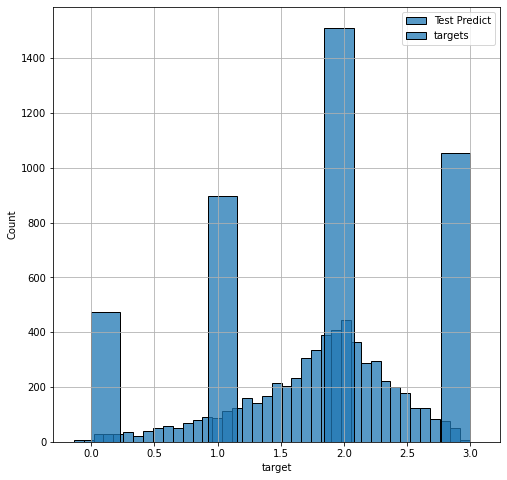

In [38]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(predictions, label='Test Predict')
sns.histplot(train_df['target'], label='targets')
ax.legend()
ax.grid()

In [39]:
import datetime
now = datetime.datetime.now()
print(now)

2021-07-22 03:56:15.369353


In [40]:
sub_df = pd.read_csv(os.path.join(input_dir, 'atmaCup#11_sample_submission.csv'))
sub_df['target'] = predictions

sub_df.to_csv(os.path.join(output_path, f'submission_{now.strftime("%m%d_%H%M")}.csv'), index=False)